100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.1MB/s]


Starting training on cpu


Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/10: 100%|██████████| 469/469 [00:52<00:00,  9.01it/s, loss_per_img=139.4200]


Epoch [1/10] Avg Loss: 104.6208 Recon: 81.2285 KL: 23.3923


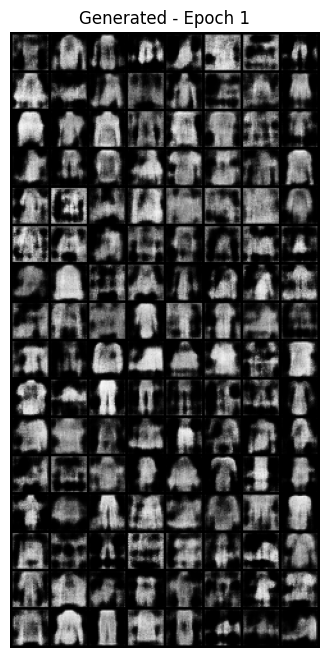

Epoch 2/10: 100%|██████████| 469/469 [00:54<00:00,  8.61it/s, loss_per_img=100.9206]


Epoch [2/10] Avg Loss: 75.5693 Recon: 52.4152 KL: 23.1541


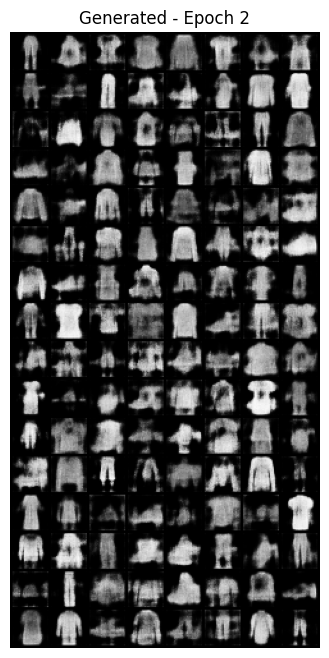

Epoch 3/10:  96%|█████████▌| 449/469 [00:54<00:02,  8.16it/s, loss_per_img=71.2048]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import numpy as np

# reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparams
image_size = 28 # FashionMNIST images are 28x28
batch_size = 128
latent_dim = 20
num_epochs = 10
learning_rate = 1e-3
root = 'data'

# Transforms for FashionMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1]
])

# Download and load FashionMNIST dataset
os.makedirs(root, exist_ok=True)
train_dataset = datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# Encoder, Decoder, VAE (adapted for FashionMNIST)
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Input: 1 x 28 x 28 (grayscale)
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), # 32 x 14 x 14
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 64 x 7 x 7
            nn.ReLU(inplace=True)
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # 32 x 14 x 14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),  # 1 x 28 x 28
            nn.Tanh() # Output in [-1, 1]
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 64, 7, 7)
        return self.deconv(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    # recon loss: MSE per-pixel (sum over all elements)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div, recon_loss, kl_div

# instantiate
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# helper: denormalize tensor from [-1,1] -> [0,1] for plotting
def denorm(img_tensors):
    imgs = img_tensors.clone()
    imgs = imgs * 0.5 + 0.5
    return torch.clamp(imgs, 0.0, 1.0)


# training loop
print(f"Starting training on {device}")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_recon = 0.0
    running_kl = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, _ in pbar:
        images = images.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(images)
        loss, recon_loss, kl_div = vae_loss(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_recon += recon_loss.item()
        running_kl += kl_div.item()

        pbar.set_postfix({
            "loss_per_img": f"{running_loss / ((pbar.n + 1) * images.size(0)):.4f}"
        })

    avg_loss = running_loss / len(train_loader.dataset)
    avg_recon = running_recon / len(train_loader.dataset)
    avg_kl = running_kl / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f} Recon: {avg_recon:.4f} KL: {avg_kl:.4f}")

    # sample from prior and visualize
    model.eval()
    with torch.no_grad():
        z = torch.randn(batch_size, latent_dim).to(device)
        sample_images = model.decoder(z)  # outputs in [-1,1]
        sample_images = denorm(sample_images.cpu())  # to [0,1]
        grid = torchvision.utils.make_grid(sample_images, nrow=8)
        plt.figure(figsize=(8,8))
        plt.imshow(grid.permute(1, 2, 0).squeeze().numpy(), cmap='gray') # Squeeze for grayscale
        plt.axis('off')
        plt.title(f"Generated - Epoch {epoch+1}")
        plt.show()

# Optional: Visualize reconstructions from test set
model.eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images.to(device)
    recon, _, _ = model(images)

    # Visualize original and reconstructed images
    fig, axes = plt.subplots(2, 8, figsize=(12, 4))
    for i in range(8):
        # Original
        axes[0, i].imshow(denorm(images[i].cpu()).squeeze().numpy(), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed
        axes[1, i].imshow(denorm(recon[i].cpu()).squeeze().numpy(), cmap='gray')
        axes[1, i].axis('off')

    fig.suptitle('Original vs Reconstructed Images', fontsize=16)
    plt.show()